# Imports and setting up

In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
import torchvision

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [3]:
cd ../task2

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/task2


In [4]:
import abbyy_course_cvdl_t2
from abbyy_course_cvdl_t2.convert import PointsToObjects, ObjectsToPoints
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.loss import CenterNetLoss

In [5]:
cd ../task3

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/task3


In [6]:
def postprocess(data, target_shape, input_shape):
    unf = {}
    res = data[data[:, -1] != 0]
    boxes = res[:, :4].copy()
    b = boxes.copy()
    result_boxes = np.zeros_like(boxes)
    result_boxes[:, 0] = (boxes[:, 1] - b[:, 3] / 2) * (target_shape[1] / input_shape[1])
    result_boxes[:, 1] = (boxes[:, 0] - b[:, 2] / 2) * (target_shape[0] / input_shape[0])
    result_boxes[:, 2] = boxes[:, 3] * (target_shape[1] / input_shape[1])
    result_boxes[:, 3] = boxes[:, 2] * (target_shape[0] / input_shape[0])
    unf['boxes'] = result_boxes
    unf['scores'] = res[:, -1]
    return unf


def extract_results(net, ds_val, ct, input_shape, device, predictions_path='predictions.json'):
    prepared_preds = []
    img_ids = []

    net.eval()

    for num, img_id in enumerate(tqdm(ds_val.ids)):
        img_id = int(img_id)
        img_meta = ct.loadImgs(ids=[img_id])[0]

        with torch.no_grad():
            x = ds_val[num][0]
            
            pred = net(
                x[None, ...].to(device),
                return_objects=True
            )[0].detach().cpu().numpy()
            prepared_preds.append(
                postprocess(pred, target_shape=(img_meta['height'], img_meta['width']), input_shape=input_shape)
            )
            img_ids.append(img_id)

    scores = np.concatenate([u['scores'] for u in prepared_preds], axis=0)
    boxes = np.concatenate([u['boxes'] for u in prepared_preds], axis=0)
    
    image_ids = []
    
    for num, i in enumerate(img_ids):
        image_ids += [i] * len(prepared_preds[num]['boxes'])
    image_ids = np.array(image_ids)

    dump_detections_to_cocotext_json(
        image_ids = image_ids.tolist(),
        xlefts=boxes[:, 0].tolist(),
        ytops=boxes[:, 1].tolist(),
        widths=boxes[:, 2].tolist(),
        heights=boxes[:, 3].tolist(),
        scores=scores.tolist(),
        path=predictions_path
    )
    
    ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path=predictions_path
    )
    return (ap, prec, rec, len(scores))


def validate(images_path, anno_path, model_dump_path, predictions_path='predictions.json', device='cpu', n_classes=2, resolution=640):
    
    _anno_path = Path(anno_path)
    _images_path = Path(images_path)

    assert _anno_path.exists(), "Set your own path to annotation"
    assert _images_path.exists(), "Set your own path to images"
    
    ct = COCO_Text(anno_path)
    input_shape = (resolution, resolution)
    
    ds_val = CocoTextDetection(
    _images_path,
    _anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
    ),
    area_fraction_threshold=1/32/32,
    split='val'
    )
    
    device = torch.device(device)
    print(device)
    net = torch.load(model_dump_path, map_location=device)
    net.to(device)
    net.eval()
    
    ap, prec, rec, n_obj = extract_results(net, ds_val, ct, input_shape, device, predictions_path=predictions_path)

    print(f"Итоговый скор AP на val: {ap}")

    plt.plot(prec, rec)
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.title('PR curve')
    plt.grid()

# Validating

In [ ]:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rNVGdD6YmqhKdMctnR-z_nTTuJ9ePSZi' -O 'model.pth'
!gdown https://drive.google.com/uc?id=1rNVGdD6YmqhKdMctnR-z_nTTuJ9ePSZi -O model.pth

In [7]:
base = Path("/home/alexander/Downloads/coco2014")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'images/train2014'
model_dump_path = 'model.pth'
predictions_path = 'predictions.json'

device = 'cuda:0'

n_classes = 2
resolution = 640

loading annotations into memory...
0:00:02.220653
creating index...
index created!
cuda:0


100%|██████████| 4446/4446 [05:36<00:00, 13.20it/s]


Loading and preparing results...     
DONE (t=0.32s)
Итоговый скор AP на val: 0.3730886187212715


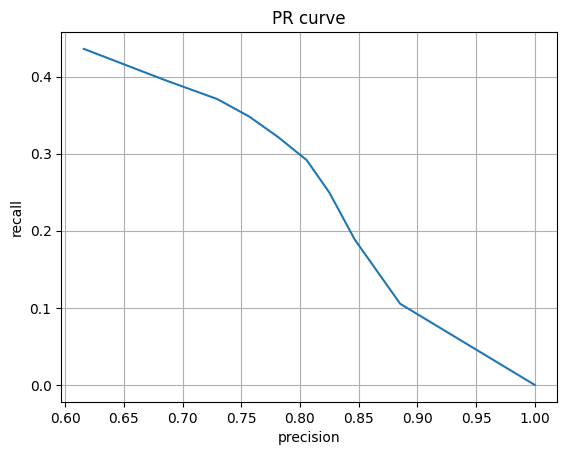

In [8]:
validate(images_path=images_path, anno_path=anno_path, 
         model_dump_path=model_dump_path, predictions_path=predictions_path, 
         device=device, n_classes=n_classes, resolution=resolution)